Importação de Bibliotecas Utilizadas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
import joblib
from prophet import Prophet
import glob
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import os
from datetime import timedelta
from prophet.plot import plot_plotly
import plotly.offline as py

c:\Users\gabri\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Carregamento de Dados

In [11]:
csv_horario = "../data/processed/media_horaria/part-00000-59700da2-f5b6-4b4f-b32b-d7f6740de0c5-c000.csv"  # ou caminho exato
df = pd.read_csv(csv_horario)

# Criar coluna ds
df["ds"] = pd.to_datetime(df["date"] + " " + df["hour"].astype(str) + ":00:00")
df = df[["ds", "media_temp"]].rename(columns={"media_temp": "y"})

# Ordenar cronologicamente
df = df.sort_values('ds')


Importação do Modelo

In [14]:
model = joblib.load("../models/previsao_horaria.pkl")


Fazer Previsão

In [21]:
dias_futuros = 48
future = model.make_future_dataframe(periods=dias_futuros, freq='H')
forecast = model.predict(future)

c:\Users\gabri\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



DEBUG	Task(Task-2) cmdstanpy:command.py:do_command()- cmd: where.exe tbb.dll
cwd: None
DEBUG	Task(Task-2) cmdstanpy:model.py:__init__()- TBB already found in load path
INFO	Task(Task-2) prophet:forecaster.py:parse_seasonality_args()- Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG	Task(Task-2) cmdstanpy:filesystem.py:_temp_single_json()- input tempfile: C:\Users\gabri\AppData\Local\Temp\tmpg80697_g\lr_d8a9i.json
DEBUG	Task(Task-2) cmdstanpy:filesystem.py:_temp_single_json()- input tempfile: C:\Users\gabri\AppData\Local\Temp\tmpg80697_g\w7e6594m.json
DEBUG	Task(Task-2) cmdstanpy:model.py:_run_cmdstan()- idx 0
DEBUG	Task(Task-2) cmdstanpy:model.py:_run_cmdstan()- running CmdStan, num_threads: None
DEBUG	Task(Task-2) cmdstanpy:model.py:_run_cmdstan()- CmdStan args: ['C:\\Users\\gabri\\AppData\\Local\\Programs\\Python\\Python313\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=74630', 'data', 'file=C:\\Users\\gabri

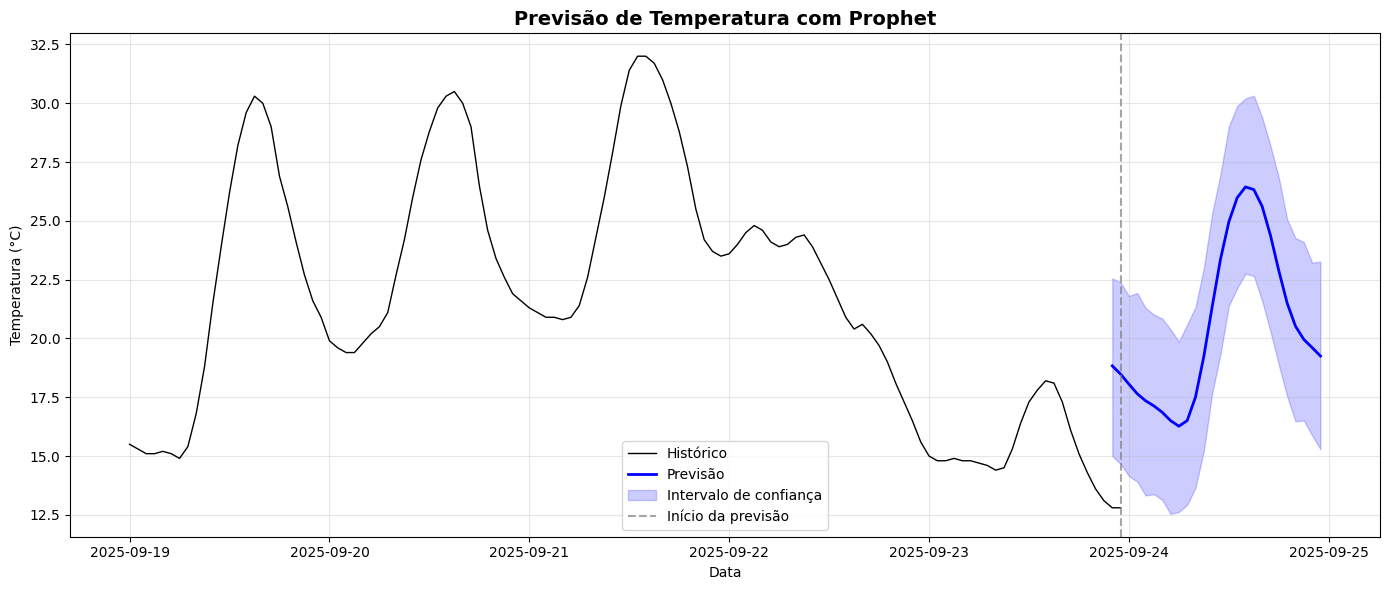

In [28]:
# Preparação dos dados
df_prophet = df.reset_index().rename(columns={"time": "ds", "temperature_2m": "y"})
m = Prophet()
m.fit(df_prophet)

# Criar datas futuras
future = m.make_future_dataframe(periods=24, freq="H")
forecast = m.predict(future)

# Definir a data limite para o histórico
data_limite = df_prophet["ds"].max() - pd.Timedelta(days=7)

# Filtrar histórico
df_hist_recent = df_prophet[df_prophet["ds"] >= data_limite]

# Filtrar previsão (mantém só as datas >= última data do histórico)
forecast_recent = forecast[forecast["ds"] >= df_prophet["ds"].max() - pd.Timedelta(hours=1)]

# Plot
fig, ax = plt.subplots(figsize=(14, 6))

# Série histórica (apenas últimos 7 dias)
ax.plot(df_hist_recent["ds"], df_hist_recent["y"], color="black", label="Histórico", linewidth=1)

# Previsão (apenas 24h após histórico)
ax.plot(forecast_recent["ds"], forecast_recent["yhat"], color="blue", label="Previsão", linewidth=2)

# Intervalo de confiança
ax.fill_between(
    forecast_recent["ds"],
    forecast_recent["yhat_lower"],
    forecast_recent["yhat_upper"],
    color="blue",
    alpha=0.2,
    label="Intervalo de confiança"
)

# Melhorias visuais
ax.axvline(df_prophet["ds"].max(), color="gray", linestyle="--", alpha=0.7, label="Início da previsão")
ax.set_title("Previsão de Temperatura com Prophet", fontsize=14, weight="bold")
ax.set_xlabel("Data")
ax.set_ylabel("Temperatura (°C)")
ax.grid(alpha=0.3)
ax.legend()

plt.tight_layout()
plt.savefig("../assets/previsao_temp.png", bbox_inches="tight")
plt.show()


Visualizações

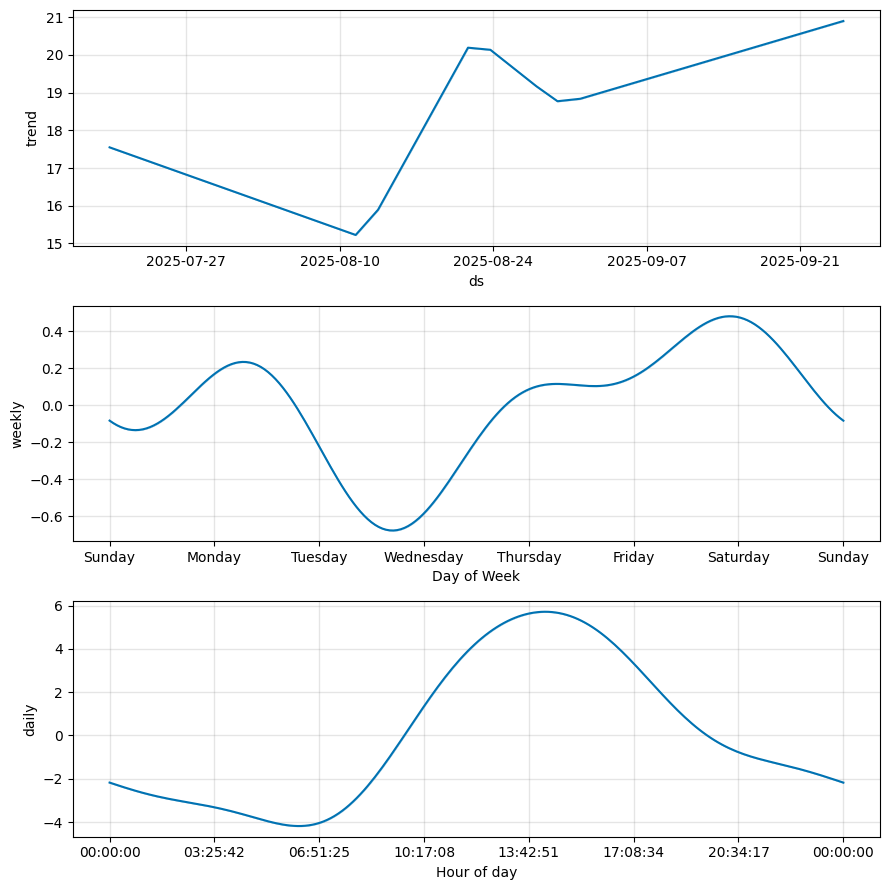

In [29]:
model.plot_components(forecast)
# Salvar imagem do gráfico
plt.savefig(r'../assets/forecast.png')
plt.show()


In [23]:
py.init_notebook_mode(connected=True)
fig = plot_plotly(model, forecast)
fig.show()
